# Can we predict the category of an app from the app's description?

We wanted to see if we can create a Machine Learning model that will accuretly predict the category of an app from the app's description. To do this we created a web scraper to scrape data from the GooglePlay Store. After cleaning our data, we performed NLTK, Feature Engineering and Model Fitting to create an optimal ML Model. 

<br>

## Web Scraping

We created a web scraper to collect 60 app descriptions per category for 18 categories. After collecting our data we saved it to a file in dictionary format. 

In [3]:
import re
import pandas as pd
import numpy as np
read_dictionary = np.load('my_file.npy').item()

data  = read_dictionary

print(data.keys())
data['EDUCATION']

dict_keys(['EDUCATION', 'BUSINESS', 'DATING', 'SPORTS', 'WEATHER', 'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'BEAUTY', 'MUSIC_AND_AUDIO', 'NEWS_AND_MAGAZINES', 'SOCIAL', 'SHOPPING', 'PRODUCTIVITY', 'PHOTOGRAPHY', 'MEDICAL', 'PARENTING', 'COMMUNICATION', 'TOOLS'])


["⭐Es una App genial porque aprendes palabras nuevas y practicas la pronunciación a cada momento que desbloqueas tu pantalla.⭐Aprendes cada vez que abres tu teléfono. La forma más inconsciente de aprender eficazmente.¿Cuántas veces miras tu móvil al día?Lo miras un promedio de 100 veces al día y lo desbloqueas al menos 50 veces.¡Si estudiaras vocabulario en esos momentos en los que miras el móvil, podrías aprender unas 3,000 palabras en tan solo un mes!Wordbit inglés es una App que te permite estudiar inglés desde la pantalla de bloqueo de tu móvil.Excava valiosos tesoros desde tu pantalla bloqueada. Formará parte de tu rutina de aprendizaje.Además, ¡es totalmente gratis! ■ La memorización del vocabulario es la clave para el aprendizaje de cualquier lengua extranjeray la técnica más básica para memorizar el vocabulario es la repetición.Puedes memorizar el vocabulario mirándolo repetidamente y sin darte cuenta.¡Nuestra aplicación no sólo te ayudará a aprender nuevas palabras, sino tambi

<br>

## NLTK: Natural Language Tool Kit

In [4]:
import nltk
import sklearn

from nltk.collocations import *
from nltk import FreqDist, word_tokenize
import string, re
from nltk.stem.snowball import SnowballStemmer

pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

# stop words
from nltk.corpus import stopwords
stopwords.words("english")

stop_words = set(stopwords.words('english'))

# stem words
stemmer = SnowballStemmer("english")

In [5]:
def text_cleaner(description):
    '''uses regex to tokenize words and capture them from the description, 
    lowers the capitilization remove stop words, reduce to stem words, 
    and joins them all in a string'''
    tokens_raw = nltk.regexp_tokenize(description, pattern)
    tokens = [i.lower() for i in tokens_raw]
    tokens_stopped = [w for w in tokens if not w in stop_words]
    stemmed = [stemmer.stem(word) for word in tokens_stopped]
    cleaned = ' '.join(stemmed)
    return cleaned



def dict_cleaner(dictionary):
    '''iterates through the dictionary values in each key (category) 
    and cleans each description and adds it back to a new list'''
    description_list = []
    for c, d in dictionary.items():
        for description in d:
            cleaned = text_cleaner(description)
            description_list.append(cleaned)
    return description_list


#use our function on our data
description_list = dict_cleaner(data)

#turn into df
new_df = pd.DataFrame(description_list, columns=['desc'])

In [6]:
new_df.head()

,desc
0,es una app genial porqu aprend palabra nueva p...
1,unlock math calcul math solut take photo math ...
2,learn anyth free forev spend afternoon brush s...
3,updat info latest updat new section ad learn l...
4,join million learner learn code make app game ...


<br>

## Frequency Distributions

In [65]:
i = 0
listy = []
for key in data.keys():
    string = ''
    for x in range(i, i + 60):
        string += description_list[i]
    listy.append(string)
    i += 60
    
def get_most_common(keys, lis_t, n_words=50):
    key_words = []
    for key, string in zip(keys, lis_t):
        meta_freqdist = FreqDist(string.split())
        key_words.append((key, meta_freqdist.most_common(n_words)))
    return key_words

key_words = get_most_common(data.keys(), listy)
key_words

[('EDUCATION',
  [('de', 2220),
   ('n', 1320),
   ('la', 1140),
   ('learn', 840),
   ('para', 780),
   ('vocabulario', 600),
   ('el', 600),
   ('vocabulari', 600),
   ('aprend', 480),
   ('palabra', 480),
   ('que', 480),
   ('tu', 480),
   ('en', 480),
   ('aplicaci', 480),
   ('c', 480),
   ('word', 480),
   ('english', 480),
   ('applic', 480),
   ('ingl', 420),
   ('b', 420),
   ('expresion', 420),
   ('time', 420),
   ('express', 420),
   ('app', 360),
   ('wordbit', 360),
   ('frase', 360),
   ('autom', 360),
   ('phrase', 360),
   ('option', 360),
   ('automat', 360),
   ('es', 301),
   ('una', 300),
   ('las', 300),
   ('use', 300),
   ('lo', 240),
   ('los', 240),
   ('aprendizaj', 240),
   ('pued', 240),
   ('ielt', 240),
   ('toefl', 240),
   ('etc', 240),
   ('con', 240),
   ('audio', 240),
   ('por', 240),
   ('everi', 240),
   ('phone', 240),
   ('pronunciaci', 180),
   ('cada', 180),
   ('pantalla', 180),
   ('forma', 180)]),
 ('BUSINESS',
  [('manag', 420),
   ('mone

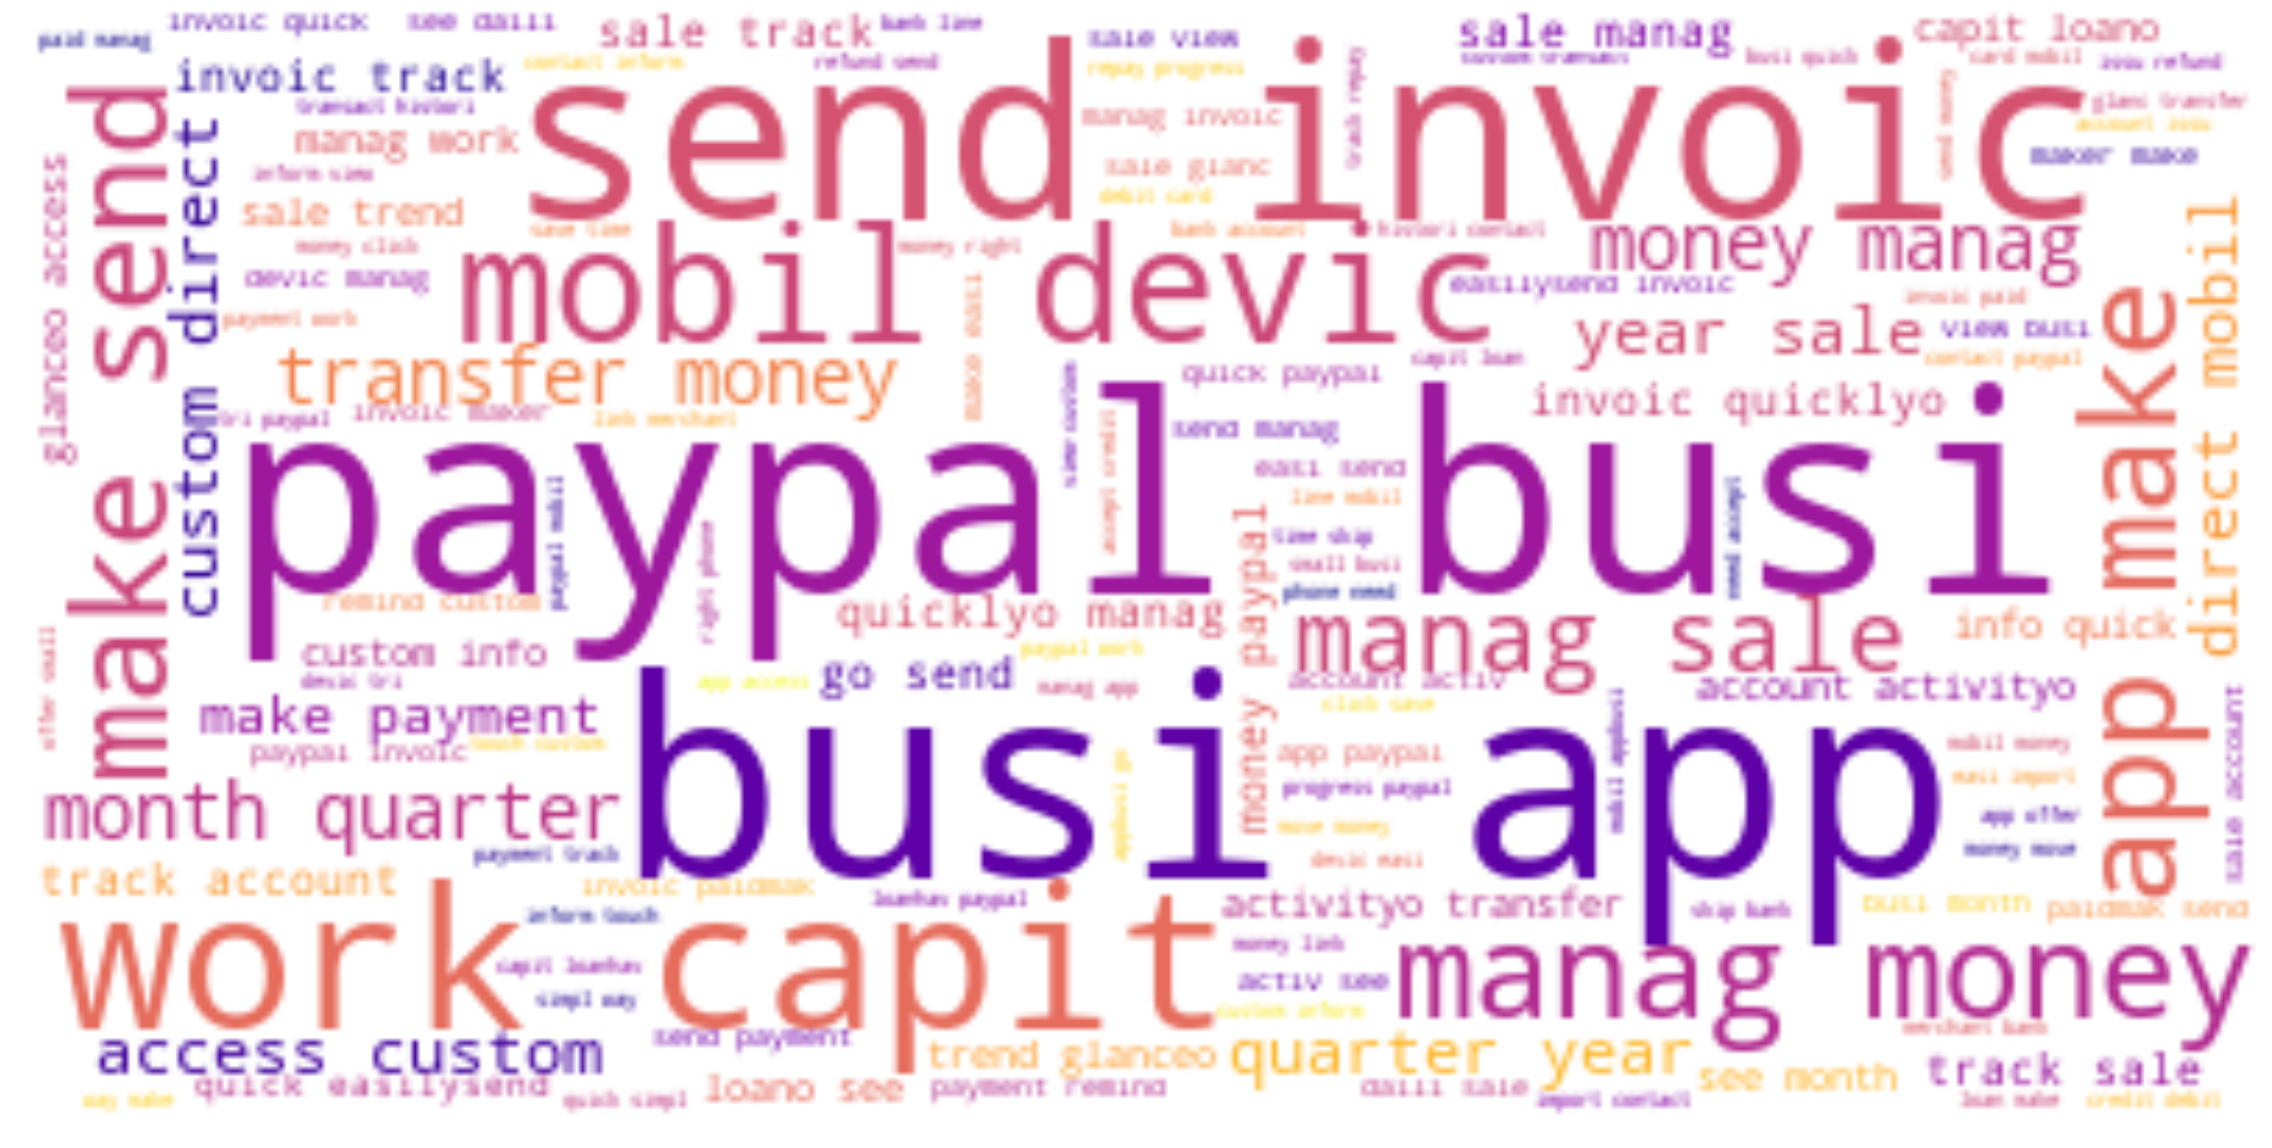

In [64]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

wordcloud = WordCloud(colormap='plasma', max_font_size=50, max_words=200, background_color="white").generate(listy[1])

# Display the generated image dating:
plt.figure(figsize=[40,40])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<br>

## Test-Train-Split

In [7]:
#We have to create labels in order to label the words that appear in each category
def create_labels(dictionary):
    x = dictionary.keys()
    new_list = []
    for c in x: 
        s = [c] * len(dictionary[c])
        new_list += s
    return new_list


labels = create_labels(data)
new_df['labels'] = labels

print(new_df.shape)
new_df.columns

(1080, 2)


Index(['desc', 'labels'], dtype='object')

<br>

In [8]:
#we set our labels to y and set our features to x
y = new_df.labels

X = new_df.desc

#set our train and test data
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


<br>

## TF-IDF

We use Tf-Idif function to transform our data to reflect how important a word is in the collection of descriptions in each category.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

X_train = tfidf.fit_transform(X_train)

# X_train = pd.DataFrame(train_df.toarray(), columns=tfidf.get_feature_names())

X_test = tfidf.transform(X_test)

In [10]:
X_test

<216x11665 sparse matrix of type '<class 'numpy.float64'>'
	with 22699 stored elements in Compressed Sparse Row format>

<br>

## Corpus Statistics

How many non-zero elements are there?

In [11]:
non_zero_cols = X_train.nnz / float(X_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Reviews: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(X_train.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Reviews: 112.73032407407408
Percentage of columns containing 0: 0.9903360202251115


<br>

## K-Nearest Neighbor

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
knn_train_preds = knn.predict(X_train)
knn_test_preds = knn.predict(X_test)

knn_train_score = accuracy_score(y_train, knn_train_preds)
knn_test_score = accuracy_score(y_test, knn_test_preds)

print("KNN")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(knn_train_score, knn_test_score))
print("F1 Score: {}".format(f1_score(y_test, knn_test_preds, average='micro')))

KNN
Training Accuracy: 0.831 		 Testing Accuracy: 0.7639
F1 Score: 0.763888888888889


<br>

## Naive-Bayes Multinomial Classifier

In [13]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()

nb_classifier.fit(X_train, y_train)
nb_train_preds = nb_classifier.predict(X_train)
nb_test_preds = nb_classifier.predict(X_test)

nb_train_score = accuracy_score(y_train, nb_train_preds)
nb_test_score = accuracy_score(y_test, nb_test_preds)

print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))
print("F1 Score: {}".format(f1_score(y_test, nb_test_preds, average='micro')))

Multinomial Naive Bayes
Training Accuracy: 0.9213 		 Testing Accuracy: 0.7454
F1 Score: 0.7453703703703705


<br>

## Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=50)

rf_classifier.fit(X_train, y_train)
rf_train_preds = rf_classifier.predict(X_train)
rf_test_preds = rf_classifier.predict(X_test)

rf_train_score = accuracy_score(y_train, rf_train_preds)
rf_test_score = accuracy_score(y_test, rf_test_preds)

print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))
print("F1 Score: {}".format(f1_score(y_test, rf_test_preds, average='micro')))

Random Forest
Training Accuracy: 1.0 		 Testing Accuracy: 0.7083
F1 Score: 0.7083333333333334


<br>

## SVM

In [15]:
from sklearn import svm

svm_clf = svm.SVC(probability=True)

svm_clf.fit(X_train, y_train)
svm_train_preds = rf_classifier.predict(X_train)
svm_test_preds = rf_classifier.predict(X_test)

svm_train_score = accuracy_score(y_train, svm_train_preds)
svm_test_score = accuracy_score(y_test, svm_test_preds)

print('SVM')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(svm_train_score, svm_test_score))
print("F1 Score: {}".format(f1_score(y_test, svm_test_preds, average='micro')))

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM
Training Accuracy: 1.0 		 Testing Accuracy: 0.7083
F1 Score: 0.7083333333333334


<br>

## TPOT for automated model selection

In [ ]:
from tpot import TPOTClassifier


tpot = TPOTClassifier(generations=5, cv = 3 ,population_size=20,\
                      max_eval_time_mins=10, verbosity=3)


#we ran the classifier, which will tell us the best model to use.
tpot.fit(X_train, y_train)


'''After changing the generation and population parameters to get better results, 
   we came up with the final best result. 
   The Automated model selection gave us the best model to use which yielded: 
   
   
   exported_pipeline = LinearSVC(C=1, dual=True, loss="squared_hinge", penalty="l2")
   
   svc = LinearSVC(C=0.5, dual=True, loss="squared_hinge", penalty="l2", tol=0.001)'''



<br>

## LinearSVC

In [16]:
from sklearn.svm import LinearSVC

lsvc_classifier = LinearSVC(C=10.0, dual=False, loss="squared_hinge", penalty="l2", tol=0.1)

lsvc_classifier.fit(X_train, y_train)
lsvc_train_preds = lsvc_classifier.predict(X_train)
lsvc_test_preds = lsvc_classifier.predict(X_test)

lsvc_train_score = accuracy_score(y_train, lsvc_train_preds)
lsvc_test_score = accuracy_score(y_test, lsvc_test_preds)

print('LinearSVC')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(lsvc_train_score, lsvc_test_score))
print("F1 Score: {}".format(f1_score(y_test, lsvc_test_preds, average='micro')))

LinearSVC
Training Accuracy: 1.0 		 Testing Accuracy: 0.8102
F1 Score: 0.8101851851851852


In [72]:
lsvc2_classifier = LinearSVC(C=0.5, dual=True, loss="squared_hinge", penalty="l2", tol=0.001)

lsvc2_classifier.fit(X_train, y_train)
lsvc2_train_preds = lsvc2_classifier.predict(X_train)
lsvc2_test_preds = lsvc2_classifier.predict(X_test)

lsvc2_train_score = accuracy_score(y_train, lsvc2_train_preds)
lsvc2_test_score = accuracy_score(y_test, lsvc2_test_preds)

print('LinearSVC')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(lsvc2_train_score, lsvc2_test_score))
print("F1 Score: {}".format(f1_score(y_test, lsvc_test_preds, average='micro')))

LinearSVC
Training Accuracy: 0.9861 		 Testing Accuracy: 0.8241
F1 Score: 0.8240740740740741


## Gradient Boosting

In [114]:
from sklearn.ensemble import GradientBoostingClassifier


gb_clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=6, max_features=0.2, min_samples_leaf=3, min_samples_split=15, n_estimators=100, subsample=0.25)

gb_clf.fit(X_train, y_train)
gb_train_preds = gb_clf.predict(X_train)
gb_test_preds = gb_clf.predict(X_test)

gb_train_score = accuracy_score(y_train, gb_train_preds)
gb_test_score = accuracy_score(y_test, gb_test_preds)

print('Gradient Boosting')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(gb_train_score, gb_test_score))
print("F1 Score: {}".format(f1_score(y_test, gb_test_preds, average='micro')))

Gradient Boosting
Training Accuracy: 0.9514 		 Testing Accuracy: 0.7222
F1 Score: 0.7222222222222222


<br>

## AdaBoosting

In [115]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_clf = AdaBoostClassifier()

adaboost_clf.fit(X_train, y_train)
adaboost_train_preds = adaboost_clf.predict(X_train)
adaboost_test_preds = adaboost_clf.predict(X_test)

adaboost_train_score = accuracy_score(y_train, adaboost_train_preds)
adaboost_test_score = accuracy_score(y_test, adaboost_test_preds)

print('AdaBoosting')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(adaboost_train_score, adaboost_test_score))
print("F1 Score: {}".format(f1_score(y_test, adaboost_test_preds, average='micro')))

AdaBoosting
Training Accuracy: 0.2326 		 Testing Accuracy: 0.1759
F1 Score: 0.17592592592592593


## XGBoosting

In [116]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
xgb_train_preds = xgb_clf.predict(X_train)
xgb_test_preds = xgb_clf.predict(X_test)

xgb_train_score = accuracy_score(y_train, xgb_train_preds)
xgb_test_score = accuracy_score(y_test, xgb_test_preds)

print('AdaBoosting')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(xgb_train_score, xgb_test_score))
print("F1 Score: {}".format(f1_score(y_test, xgb_test_preds, average='micro')))

AdaBoosting
Training Accuracy: 1.0 		 Testing Accuracy: 0.6759
F1 Score: 0.6759259259259259


## Voting Classifier

In [168]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

svc1 = LinearSVC(C=25.0, dual=False, loss="squared_hinge", penalty="l2", tol=0.001)
svc2 = LinearSVC(C=1.0, dual=True, loss="hinge", penalty="l2", tol=1e-05)
gb_clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=6, max_features=0.2, min_samples_leaf=3, min_samples_split=15, n_estimators=100, subsample=0.25)


vc_clf = VotingClassifier(estimators=[('svc1', svc1), 
                                     ('svc2', svc2),
                                     ('gb_clf', gb_clf),
                                    ('nb', nb_classifier),
                                    ('knn', knn),
                                    ('rf', rf_classifier)], voting='hard')

vc_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('svc1', LinearSVC(C=25.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)), ('svc2', LinearSVC(C=1.0, class_weight=None, dual=True, fit_i...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [169]:
vc_train_preds = vc_clf.predict(X_train)
vc_test_preds = vc_clf.predict(X_test)

vc_train_score = accuracy_score(y_train, vc_train_preds)
vc_test_score = accuracy_score(y_test, vc_test_preds)

print('Voting Classifier')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(vc_train_score, vc_test_score))
print("F1 Score: {}".format(f1_score(y_test, vc_test_preds, average='micro')))

Voting Classifier
Training Accuracy: 0.9745 		 Testing Accuracy: 0.8333
F1 Score: 0.8333333333333334


## PCA Experiment

In [35]:
from sklearn.decomposition import PCA

pca_X_train = pd.DataFrame(X_train.toarray(), columns=tfidf.get_feature_names())
pca_X_test = pd.DataFrame(X_test.toarray(), columns=tfidf.get_feature_names())

pca = PCA(.95)

In [86]:
new_train = pca.fit_transform(pca_X_train)

new_test = pca.transform(pca_X_test)


In [87]:
pca.n_components_

661

In [88]:
pca_lsvc_classifier = LinearSVC(C=0.5, dual=True, loss="squared_hinge", penalty="l2", tol=0.001)

pca_lsvc_classifier.fit(new_train, y_train)
pca_lsvc_train_preds = pca_lsvc_classifier.predict(new_train)
pca_lsvc_test_preds = pca_lsvc_classifier.predict(new_test)

pca_lsvc_train_score = accuracy_score(y_train, pca_lsvc_train_preds)
pca_lsvc_test_score = accuracy_score(y_test, pca_lsvc_test_preds)

print('LinearSVC')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(pca_lsvc_train_score, pca_lsvc_test_score))
print("F1 Score: {}".format(f1_score(y_test, lsvc_test_preds, average='micro')))

LinearSVC
Training Accuracy: 0.9722 		 Testing Accuracy: 0.8241
F1 Score: 0.8240740740740741


In [163]:
pca_knn = KNeighborsClassifier()

pca_knn.fit(new_train, y_train)
knn_train_preds = pca_knn.predict(new_train)
knn_test_preds = pca_knn.predict(new_test)

knn_train_score = accuracy_score(y_train, knn_train_preds)
knn_test_score = accuracy_score(y_test, knn_test_preds)

print("KNN")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(knn_train_score, knn_test_score))
print("F1 Score: {}".format(f1_score(y_test, knn_test_preds, average='micro')))

KNN
Training Accuracy: 0.8079 		 Testing Accuracy: 0.7269
F1 Score: 0.7268518518518519


In [164]:
pca_rf_classifier = RandomForestClassifier(n_estimators=50)

pca_rf_classifier.fit(new_train, y_train)
rf_train_preds = pca_rf_classifier.predict(new_train)
rf_test_preds = pca_rf_classifier.predict(new_test)

rf_train_score = accuracy_score(y_train, rf_train_preds)
rf_test_score = accuracy_score(y_test, rf_test_preds)

print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))
print("F1 Score: {}".format(f1_score(y_test, rf_test_preds, average='micro')))

Random Forest
Training Accuracy: 1.0 		 Testing Accuracy: 0.7269
F1 Score: 0.7268518518518519


### Niave Bayes Does not work with PCA since it does not take negative values

<br>

## Visual Analysis

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(y_test, lsvc_test_preds)
cate = data.keys()

Confusion matrix, without normalization
[[15  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  0  0  1  0  0  0  0  2  0  1  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  7  0  0  0  2  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  1  0 10  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  1 14  0  0  1  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0 10  1  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  0  0 13  0  1  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  4  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0]
 [ 0  0  2  1  0  0  0  0  0  0  1  0  1  0  9  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0  0]
 [ 1  1  1  0  0  0  0  0  0  0  1  0  2  0  0  

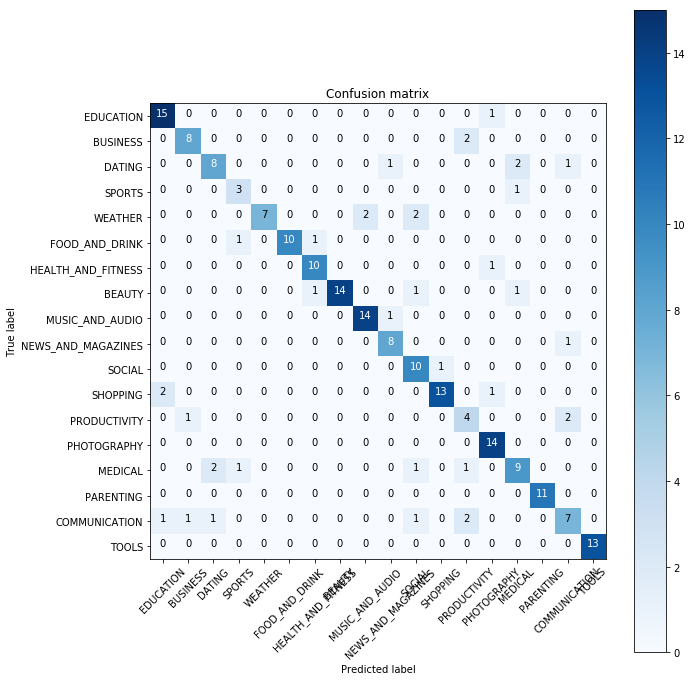

In [24]:
cm = confusion_matrix(y_test, lsvc2_test_preds)
cate = data.keys()
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, cate)

In [191]:
print('-'*60)
print('-'*7,'LineasSVC CLASSIFICATION REPORT ON TEST DATA','-'*7)
print('-'*60)
print(classification_report(y_test, lsvc2_test_preds))
print('-'*60)
print('-'*3,'LinearSVC OVERALL CLASSIFICATION REPORT ON ALL DATA','-'*3)
print('-'*60)
print(classification_report(y, lsvc2_classifier.predict(tfidf.transform(X))))
print('-'*60)
print('-'*7,'VC OVERALL CLASSIFICATION REPORT ON ALL DATA','-'*7)
print('-'*60)
print(classification_report(y, vc_clf.predict(tfidf.transform(X))))

------------------------------------------------------------
------- LineasSVC CLASSIFICATION REPORT ON TEST DATA -------
------------------------------------------------------------
                    precision    recall  f1-score   support

            BEAUTY       0.83      0.94      0.88        16
          BUSINESS       0.80      0.80      0.80        10
     COMMUNICATION       0.73      0.67      0.70        12
            DATING       0.60      0.75      0.67         4
         EDUCATION       1.00      0.64      0.78        11
    FOOD_AND_DRINK       1.00      0.83      0.91        12
HEALTH_AND_FITNESS       0.83      0.91      0.87        11
           MEDICAL       1.00      0.82      0.90        17
   MUSIC_AND_AUDIO       0.88      0.93      0.90        15
NEWS_AND_MAGAZINES       0.80      0.89      0.84         9
         PARENTING       0.67      0.91      0.77        11
       PHOTOGRAPHY       0.93      0.81      0.87        16
      PRODUCTIVITY       0.44      0

<br>

# Predicting a Random Category using our Linear SVC Model Before PCA

In [155]:
dating = """There are so many guys and girls around who'd wish to meet, chat, flirt or go dating with you! Whether you want to find a friend or find love, this app will be the best tool for achieving the goal.
Check out singles in the app, leave your "likes" for those who spark your interest or attract you, find out if they wish to chat or go out. Meet today! It might be a perfect start for new relationships!
Find out how many "likes" your photos would receive - most of those who left are singles willing to flirt.
LovePlanet unites men and women looking for relationship and brings them love!

Download the app right now to:

* to find a pal, romantic partner or your second half
* keep in touch with girls or guys you like wherever you are online
* turn your gadget into a dating tool
* be sure that your profile and conversations are absolutely secure and will only appear in your phone
* join those 800 thousand attractive singles who are about to find love and start new relationship
* Thousands of the app users meet and flirt every day - they are surely much closer to new relationship than those who haven't joined

The woman or man of your dream might be joining us right now! Get the app and be ready for love!"""

business = """New Look, same great product! Salesforce1 is now Salesforce.

Run your business from anywhere. Salesforce unifies your Chatter, CRM, custom apps, and business processes in a modern mobile app. Whether you're in the office, on an airplane, or checking in from a coffee shop, Salesforce is your key to productivity. Access all your CRM data, existing customizations, and breakthrough productivity tools from anywhere.

Manage your day.
Stay on top of your day, from viewing your scheduled events to getting updates on accounts on the go. Tap into conference calls, fast. Easily access and update your CRM data after meetings. And get the information you need, when you need it.

Advance your deals.
Sell on the go and close deals fast. Take action from anywhere on any device with contextual notifications. Get instant access to all your sales actions with the publisher, right in your feed. Log calls, create and update opportunities, and complete sales tasks.

Track your performance.
Get live updates and a real-time view of your business from the palm of your hand. Reports and Dashboards are available when you need them so you can make informed decisions from anywhere.

Collaborate with your team.
Connect with your colleagues and team members instantly, no matter where you are. Collaborate with Chatter to create, view, and manage conversations from your mobile device. Attach photos or files directly to your Chatter feed so you can keep moving and drive your business forward.

With the power of the Salesforce, you can now connect to your customers in a whole new way, all from your mobile device.

Early access to beta builds:
For early access to beta versions of the app before they are made generally available, you can sign up for access to the beta here:
https://mobilebeta.salesforce.com/"""


communication = """With This video call for Facetime app advice, You will learn the best tips and tricks with billion of features. Tips and Tricks for Facetime is the best manual for making people to be able to know how to use the app with many features.

Free FaceTime Video Call for android Guide for Everything you need to know about
FaceTime to make free calls and messages, new tips for facetime video calling free download and tricks to use facetime for android to video call

Free Facetime Video Advice This application will found a tips for Facetime Video app download and tricks to use facetime video call .
Do you want to make free facetime video chat app for android?
So this app is what you looking for is the best guide for make Facetiming free video calling on your Android device. You will discover how to use the popular facetime video call app that let you make free call

we made FaceTime for Android tips easier to understand by photo step-guides
Free Facetime Video Calling is a code of a video chatting app with a wide
range of communication features included (such as messaging, file transfer,
push notifications, audio/video calls)

*******Features of face time ************
How to record a FaceTime call
How to make a FaceTime call
How to block FaceTime calls
How to switch from a regular call to FaceTime on your phone
How to use Sirii to place a FaceTime call
How to block contacts in the FaceTime app
How to turn on FaceTime

Disclaimer:

Using this application you'll know the way to download & install and how to use many tips and tricks for Facetime video is the best manual for making people to be able to know how to use the app with many features.

This Free FaceTime Video Call Guide guide app is only an unofficial guide of Facetime

This application complies with the US Copyright law guidelines for fair use"""

tools = """Super Calculator is a professional calculator with basic, 
scientific and equation solving mode. Accurate column calculation setting, 
equation solution mode, scientific mode, etc. Scanning technology is available to identify the answer. 
And you can save your history calculation record, easy to check in when you need."""

cat_list = [dating, business, communication, tools]

In [160]:
def predict_app(x):    
    x_trial = text_cleaner(x)
    
    x_vect = tfidf.transform([x_trial])

    df_predict = pd.DataFrame(x_vect.toarray(), columns=tfidf.get_feature_names())

    return pca_lsvc_classifier.predict(pca.transform(df_predict))[0]


[predict_app(x) for x in cat_list]

['DATING', 'BUSINESS', 'COMMUNICATION', 'TOOLS']

## Voting Classifier Model

In [197]:
def vc_predict_app(x):    
    x_trial = text_cleaner(x)
    
    x_vect = tfidf.transform([x_trial])

    df_predict = pd.DataFrame(x_vect.toarray(), columns=tfidf.get_feature_names())

    return vc_clf.predict(df_predict)[0]

[vc_predict_app(x) for x in cat_list]

['DATING', 'BUSINESS', 'COMMUNICATION', 'TOOLS']

## PCA LinearSVC Model

In [161]:
def pca_predict_app(x):    
    x_trial = text_cleaner(x)
    
    x_vect = tfidf.transform([x_trial])

    df_predict = pd.DataFrame(x_vect.toarray(), columns=tfidf.get_feature_names())

    return pca_lsvc_classifier.predict(pca.transform(df_predict))[0]

[pca_predict_app(x) for x in cat_list]

['DATING', 'BUSINESS', 'COMMUNICATION', 'TOOLS']

<br>

## Use Cases for our Model

1. This can be a recommender for the GooglePlay Store or the Apple App Store when a developer is uploading their app.
2. An angel investor might double check the pitch of an app idea to see if it falls in the correct category

## Potential Problems with our Model

1. We have 60 samples per category, this might not represent the distribution of download per applications in each category in the app store.
2. We only took descriptions from the top free apps of each category.